# Regresión lineal: predecir los gastos médicos de pacientes
---

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos. 


## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [ ]:
#!pip install setuptools==58 # requieres esto para instalar regressors

#!pip install regressors


In [1]:
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [2]:
df = pd.read_csv('27_insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

(1338, 7)


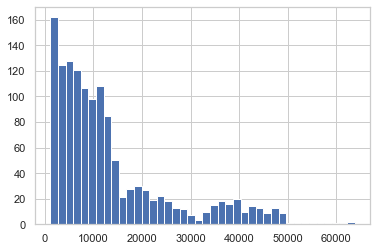

In [3]:
print(df.shape)
df.charges.hist(bins = 40);

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [4]:
df[df.charges>50000]
df = df[df.charges<50000]

En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio. 

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

## Viendo correlaciones
Ahora entendamos nuestros datos viendo cómo se distribuyen y correlacionan. 

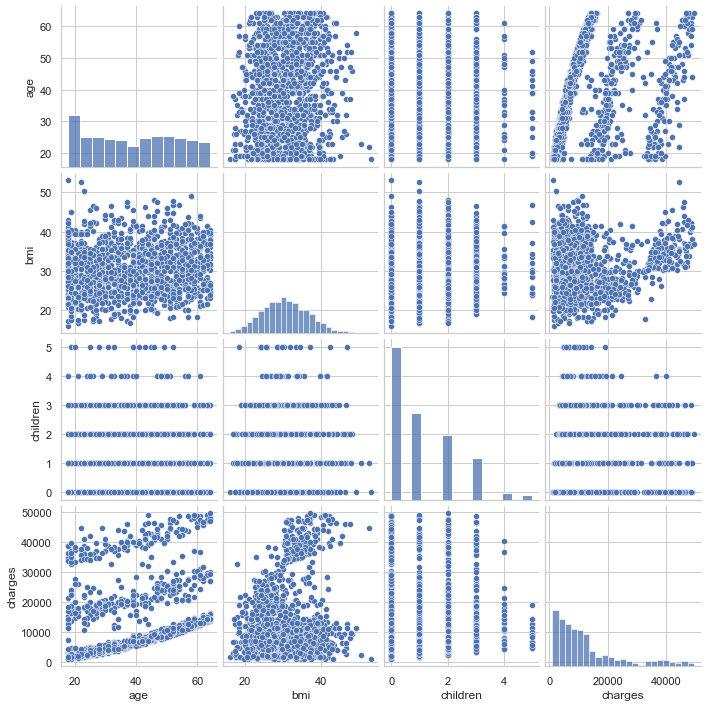

In [5]:
import matplotlib.pyplot as plt
sns.pairplot(df, height=2.5)
plt.show()

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después. **podriamos crear un modelo para cada gurpo**

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

<AxesSubplot:>

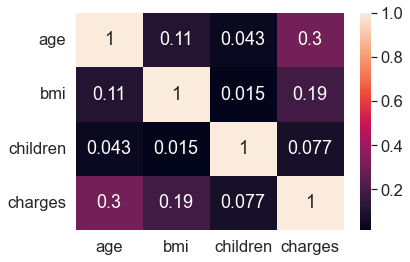

In [6]:
import numpy as np
numeric_cols = ['age', 'bmi', 'children', 'charges']
cm = np.corrcoef(df[numeric_cols].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True, yticklabels=numeric_cols,xticklabels=numeric_cols)

## encoding categorical vars
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función **[get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)** de pandas. 
recuerda que un modelo de ML no puede usar variables categoriacas a mnos que sean trasladadas a un fomrato numerico como one hot encodign. 

In [7]:
df = pd.get_dummies(df, columns=['sex','smoker','region'], drop_first=True) # drop_first elimina la necesidad de 2 columnas  sex_male and sex_famele 
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


## Creando modelos 
Primero se usará un modelo con todas las variables.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [17]:
X_cols = list(set(df.columns)-set(['charges']))
y_col = ['charges']

X = df[X_cols].values
y = df[y_col].values

# una opcion mas facil es 
# X = df.drop(['charges'], axis = 1)
# y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25 ,random_state= 42)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred.shape

(333, 1)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [21]:
import sklearn.metrics as metrics
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.764
mse:  0.2556


un r2 arriba de .75 es bueno

El siguiente código muestra un resumen general de los resultados. usando la libreria regressors
https://regressors.readthedocs.io/en/latest/usage.html 

In [22]:
from regressors import stats

# acomodamos el modelo y y_test para que pueda ser interpretado por regressors 
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1) # los coeficientes del modelo
y_test = y_test.reshape(-1)

In [23]:
print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min      1Q  Median     3Q    Max
-2.0298 -0.0788  0.1067 0.2209 0.9569


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept        0.001628    0.027847   0.0585  0.953409
region_southwest -0.044435    0.032425  -1.3704  0.171480
sex_male          0.001657    0.027922   0.0593  0.952724
children          0.060409    0.028543   2.1164  0.035054
age               0.309484    0.028164  10.9886  0.000000
region_northwest -0.017761    0.030999  -0.5729  0.567070
region_southeast -0.046864    0.034654  -1.3523  0.177193
smoker_yes        0.788674    0.026701  29.5372  0.000000
bmi               0.142602    0.028140   5.0675  0.000001
---
R-squared:  0.76398,    Adjusted R-squared:  0.75815
F-statistic: 131.10 on 8 features


## interpretacion del summary 
- estimate: nos indica el valor del coeficiente(W) para cada variable 
- std error: nos indica con que intensidad fue cambiando W (estiamte)
- p value: nos indica si debemos utilizar la variable o no. podemos eliminar variables que no sirven 

r2 ajustada siempre sera menor a r2, en este caso como ambas son muy parecidas nos indica que no hay problema en conservar todas las variables en nuestro modelo. 

valores residuales: nos permitiran ver la dispercion de los datos respecto a 0 que representa la linea del modelo. 

Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

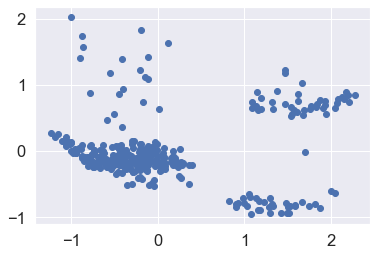

In [24]:
residuals = np.subtract(y_test, y_pred.reshape(-1)) # =  y_test - y_pred   
plt.scatter(y_pred, residuals) # comapramos la Y_pred(esta en rango -1, 2 dado a StandardScaler) vs los residuos estandarizados 
plt.show()


los residuos se utilizan para ver si el modelo de regression es el adecuado 
un residual es la diferencia entre el valor estimado y el valor observado. nos permite ver:
- si la correlacion entre las variables es lineal 

- en este caso como no se encontro ningun valor de los residuos estandarizados >2 o > -2 podempos decir que el modelo de ajuste de  regresion lineal es adecuado. 

- vemos como el modelo predice bien cuando y_pred esta de -1, 0 pero tiene un poco de fallas(los datos no estan tan alejados de la linea del modelo, si fuera alto el fallo estarian fuera del -2,2) de 1,2. la escala de -1,2 la establece el StandardScaler
para entender mas sobe los reciduos ver este video: 
https://www.youtube.com/watch?v=M8U8TWrQnbQ



# mejorando el modelo 

## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones o eliminacion sobre las variables  que pueden ser de utilidad.

In [25]:
df_second = df.copy()
df_second['age2'] = df_second.age**2 # elevamos al cuadrado por que es la variable con mayor relacion 
df_second['sobrepeso'] = (df_second.bmi >= 30).astype(int)# creamos una columna con binarios 1,0 con bmi mayor a 30
df_second['sobrepeso*fumador'] = df_second.sobrepeso * df_second.smoker_yes 
df_second.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age2,sobrepeso,sobrepeso*fumador
0,19,27.900,0,16884.92400,0,1,0,0,1,361,0,0
1,18,33.770,1,1725.55230,1,0,0,1,0,324,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0,784,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0,1089,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0,1024,0,0


Analizando el segundo modelo, con las 3 nuevas columnas creadas

In [53]:
X_cols = df_second.drop(['charges'], axis = 1).columns
y_col = ['charges']

X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression() # fit_intercept=False
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.88
mse:  0.1202


In [54]:
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1) # los coeficientes del modelo
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min     1Q  Median    3Q    Max
-1.8712 0.0457  0.1029 0.143 1.4084


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.001699    0.019188   0.0886  0.929477
age               -0.031419    0.105751  -0.2971  0.766573
bmi                0.075378    0.028563   2.6391  0.008706
children           0.071020    0.020607   3.4464  0.000641
sex_male          -0.015981    0.019203  -0.8322  0.405896
smoker_yes         0.462563    0.027367  16.9022  0.000000
region_northwest  -0.009245    0.023710  -0.3899  0.696852
region_southeast  -0.038851    0.023173  -1.6765  0.094574
region_southwest  -0.047155    0.021510  -2.1922  0.029061
age2               0.353591    0.104722   3.3765  0.000821
sobrepeso         -0.055504    0.029459  -1.8841  0.060423
sobrepeso*fumador  0.494484    0.027079  18.2608  0.000000
---
R-squared:  0.88004,    Adjusted R-squared:  0.87593
F-statistic: 214.09 on 11 features


## +++ reduccion de variables 
- en general podemos utilizr el valor de p para eliminar variabvles que no aportan informacion en la prediccion del modelo
- podemo eliminar todas las variables que tengan un valor mayor a 0.5
- en este caso consevaremos solo las 4 variables con el p mas bajo
la variable de _intercept la definimos al instanciar el modelo de RL

In [95]:
# organizamos los valor de p de menor a mayor para escoger las variables(cols) con el valor de p mas bajo
p_v = list(stats.coef_pval(model, X_test, y_test))
cols = pd.Series((X_cols)).tolist()
cols.insert(0,"_intercept")
p_values = pd.DataFrame(p_v, index= cols, columns= ["p_val"])
p_values["p_val"].sort_values()

smoker_yes           0.000000
sobrepeso*fumador    0.000000
children             0.000641
age2                 0.000821
bmi                  0.008706
region_southwest     0.029061
sobrepeso            0.060423
region_southeast     0.094574
sex_male             0.405896
region_northwest     0.696852
age                  0.766573
_intercept           0.929477
Name: p_val, dtype: float64

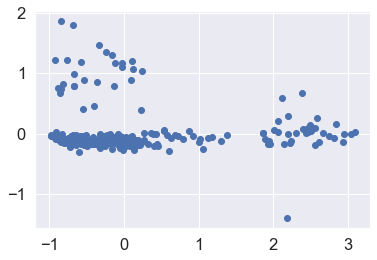

In [96]:
# graficamos los residuales para tener referencia de desempeño 
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()

In [97]:
X_cols = ['sobrepeso*fumador', 'smoker_yes', 'age2', 'children'] # solo escogemos las 4 variables con el p mas bajo 
y_col = ['charges']

X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression(fit_intercept=False) # asi eliminamos la variable de intercept 
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2 ", r2.round(4))
print("mse: ", mse.round(4))
# el modelo solo bajo 0.01 y eliminamos 8 variables que como vemos no servian de mucho

r2  0.8671
mse:  0.1481


In [98]:
model.coef_ = model.coef_.reshape(-1)
y_test = y_test.reshape(-1)

print("==========Summary==========")
stats.summary(model, X_test, y_test, X_cols)

==========Summary==========
Residuals:
    Min     1Q  Median     3Q    Max
-1.9277 0.0669  0.1138 0.1357 1.5555


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000000    0.021153   0.0000  1.000000
sobrepeso*fumador  0.499901    0.025516  19.5915  0.000000
smoker_yes         0.455140    0.026889  16.9264  0.000000
age2               0.318520    0.020511  15.5288  0.000000
children           0.058225    0.021522   2.7054  0.007175
---
R-squared:  0.86708,    Adjusted R-squared:  0.86546
F-statistic: 534.92 on 4 features


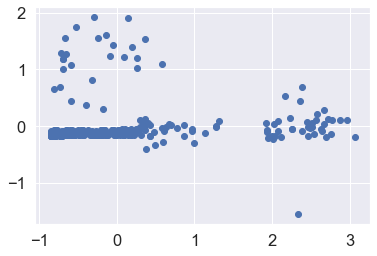

In [99]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()
# ahora tenemos un modelo con los residuales mas ajustados al modelo lo cual a mejorado mucho nuestro modelo 